### Notebook to study the charge histograms from SiPM calibration

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.stats as scs
from functools import partial

**Load in relevant data**

The data is a 2D array, formatted channel by channel.

[0] -> Channel 0 ADC values

[1] -> Channel 1 ADC values

[2] -> Channel 2 ADC values

[3] -> ...

ADC values here mean the charge value integrated over each waveform. If this isn't understood please ask :) 

Channel 1 ADC values
[-608.768     305.60004  -900.032    ... -828.8641   -368.00003
   67.455986]


Text(0, 0.5, 'Counts')

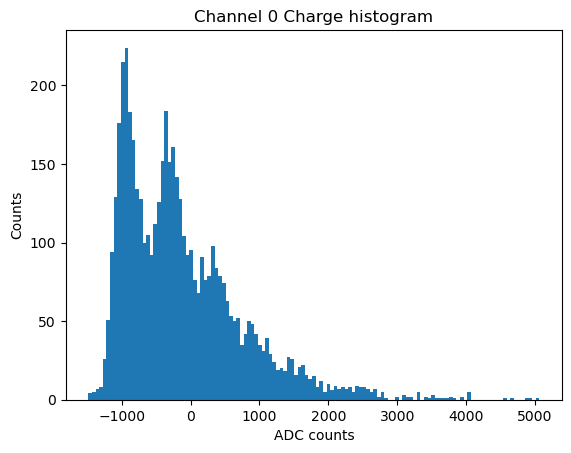

In [10]:
adc_data = np.load('ADC_data.npy')

# Example
print("Channel 1 ADC values")
print(adc_data[1])
plt.hist(adc_data[1], bins = 125)
plt.title("Channel 0 Charge histogram")
plt.xlabel("ADC counts")
plt.ylabel("Counts")

### Fitting scripts

We want to fit a selection of gaussians to this distribution. These gaussians are distributed poissonianly. Again, this is something you'll want to ask about I believe, but its all stats :)

In [39]:
def finger_signal(xs, bl, amp, gain, sigmabl, sigmaq, poismu, maxpercent=0.99999):

    '''
    A function that returns a `finger plot' distribution; a
    poissonian distribution convoluted with gaussians. This distribution
    characterises the output expected from a PMT/SiPM charge histogram
    where x is the charge or PEs and y is the number of counts.
    Parameters
    ----------
    xs             : An array of 'x' values, typically PEs or ADCs
    bl             : The value beyond zero at which the poisson peaks occur [1]
    amp            : The amplitude applied to the poissonian peaks
    gain           : The gain (shift in x) applied to the poissonian peaks
    sigmabl        : The inherent sigma of each gaussian.
    sigmaq         : The sigma of each gaussian related to which poisson peak
                     it's related to.
    maxpercent     : The percentage of the poissonian distribution that is  
    Returns
    -------
    result         : The expected y values that given (x,y) describe the
                     finger plot distribution.
    Footnotes
    ---------
    [1] Generally these peaks would initialise at begin at x = 0 but in
    practice this isn't always the case
    '''

    # Collect the position and amplitudes of the finger plot peaks
    poispeaks_pos = np.arange(0, scs.poisson.ppf(maxpercent, poismu))
    realpeaks_pos = gain * poispeaks_pos + bl
    realpeaks_amp = amp * scs.poisson.pmf(poispeaks_pos, poismu)

    # start y values collection
    result        = np.zeros_like(xs)

    # generate y values (results) that describe the poissonian distribution with
    # gaussian convolution across each peak
    for i in range(0, len(poispeaks_pos)):
            result += realpeaks_amp[i] * scs.norm.pdf(xs, loc=realpeaks_pos[i],
                                                    scale=np.sqrt(sigmabl**2 + sigmaq**2 * i))
    return result

def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# then we redefine this function where the last argument is always set for us
func = partial(finger_signal, maxpercent=0.9999999999)

To attempt a fit. Need seeds (first guess for the parameters) and bounds (limits for how high/low they can go)

In [23]:
parameter_labels = ('bl', 'amp', 'gain', 'sigmabl', 'sigmaq', 'poismu')

seeds = [-1000, 500000, 800, 100, 1, 1]
bounds = [[-np.inf, -np.inf, -np.inf, 0.0, 0.0, 0.0,], [np.inf, np.inf, np.inf, np.inf, 100, np.inf,]]


# define the number of bins here for consistency
binning = 100

# Collect the data from histogram as bins and heights
heights, bin_edges = np.histogram(adc_data[1], bins = binning)
# select bin centres
bins = (bin_edges[:-1] + bin_edges[1:]) / 2

# set uncertainty (poissonian)
uncertainty = np.sqrt(heights)
uncertainty[uncertainty == 0] = 1


In [31]:
# attempt the fit. read the documentation on curve_fit to understand what each argument means
fit_result = sco.curve_fit(func, bins, heights, p0 = seeds, bounds = bounds, maxfev = 50000, sigma = uncertainty, absolute_sigma=True)

        Fitting output      
bl: -931.7897 ± 6.0790
amp: 313443.5656 ± 4542.7393
gain: 634.0411 ± 5.7697
sigmabl: 168.6150 ± 4.3797
sigmaq: 100.0000 ± 9.7717
poismu: 1.1926 ± 0.0208


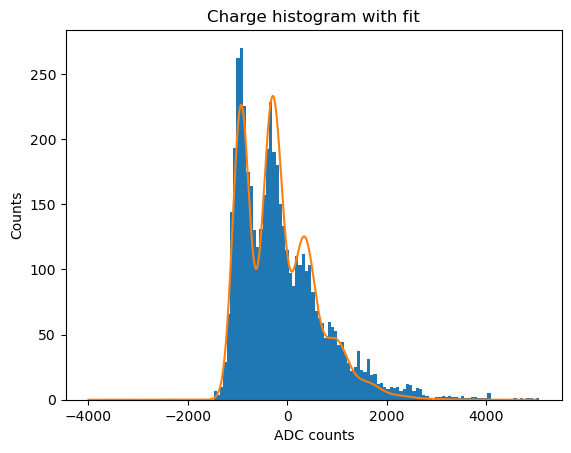

In [38]:
# create plotting space
xaux = np.linspace(-4000, 5000, 10000)

plt.hist(adc_data[1], bins = binning, label = 'data')
plt.plot(xaux, func(xaux, *fit_result[0]), label = 'fit')

print_parameters(fit_result[0], fit_result[1], parameter_labels)

plt.xlabel('ADC counts')
plt.ylabel('Counts')
plt.title("Charge histogram with fit")
plt.show()

### To do

- create a script that will plot all the different channels 
- Attempt to adjust the fitting script to add a gamma distribution to characterise the background
(https://en.wikipedia.org/wiki/Gamma_distribution)
- Demonstrate that this improves/worsens your result! (chi square comparison between fit and data would work)
- If it worsens it, look for differing distributions that would improve the fit functionality.